# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

First, I'll import the libraries needed.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order


Now, I'll load the data and resample it into hours. I'll also drop any missing values.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analysis

Next, I'll look at the data and plot a graph of it, then split it with the seasonal decompose function to get an even better picture of what the data is doing.

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


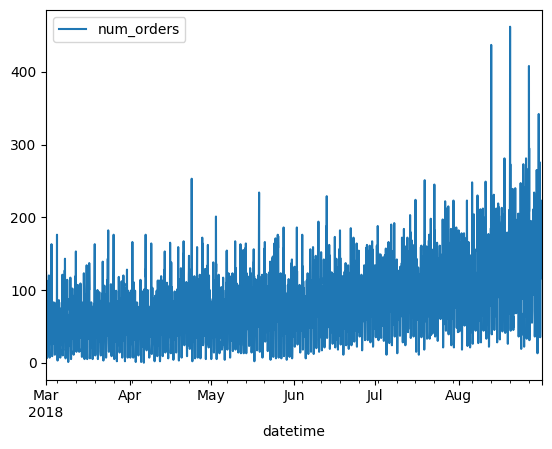

In [3]:
print(data.head())
data.plot()
plt.show()

Text(0.5, 1.0, 'Residuals')

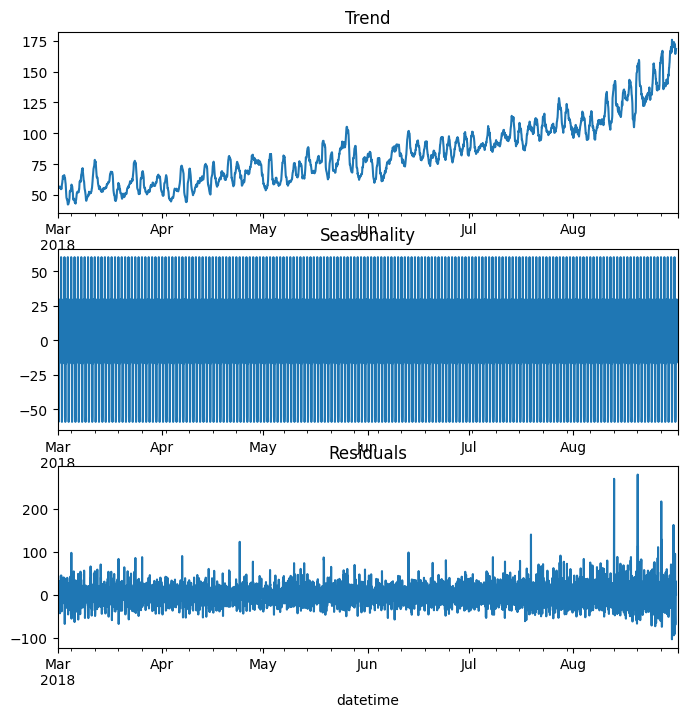

In [4]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

The Trend grid is showing a gradual increase in rides per hour as it goes later into summer and the Seasonality grid is showing consistent repetition

Since there is a lot of data and in the graph, it's hard to identify any patterns, I will make a graph showing the last 100 values of the data, to see if there is something that can be easier to identify.

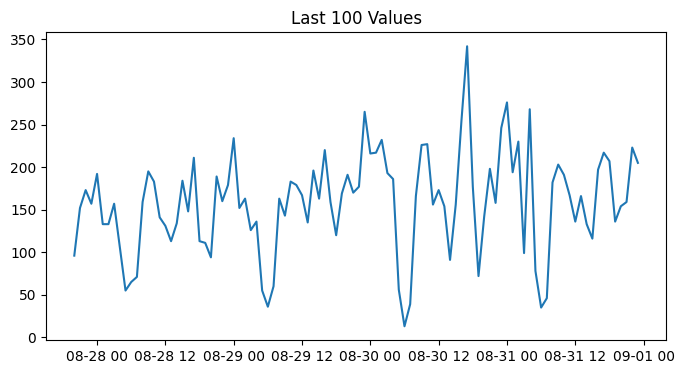

Text(0.5, 1.0, 'Residuals')

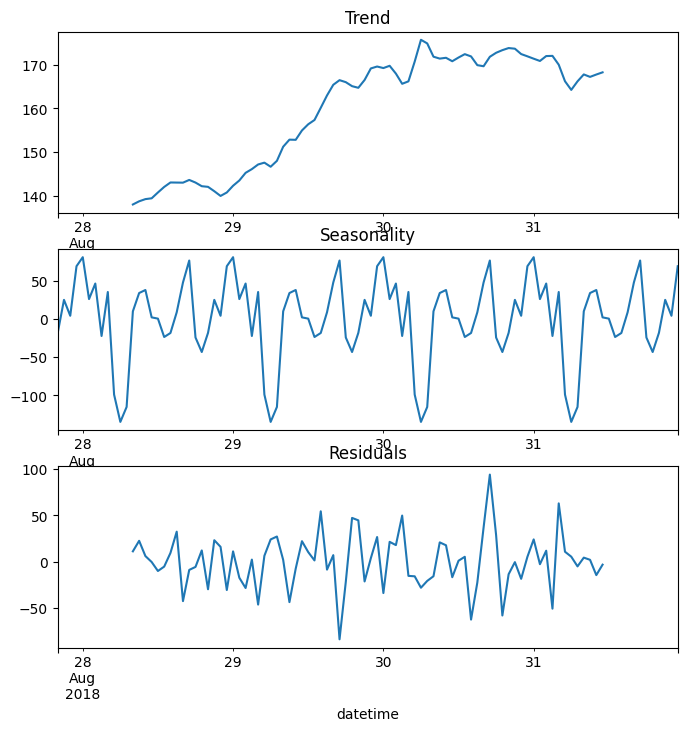

In [24]:
decomposed100 = data['num_orders'].iloc[-100:]
decomp = seasonal_decompose(decomposed100)
plt.figure(figsize=(8,4))
plt.plot(decomposed100)
plt.title("Last 100 Values")
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(311)
decomp.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomp.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomp.resid.plot(ax=plt.gca())
plt.title('Residuals')

Here we see that the trend graph is still showing an increase and the seasonal graph is showing a clearer repetition.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

    
# max_lag will be 24 for the hours in a day
# rolling mean will also be 24 for the hours in a day
make_features(data,24,24)

train, test = train_test_split(data, shuffle=False, test_size=0.10)
train = train.dropna()

print(train.shape)
print(test.shape)

(3950, 30)
(442, 30)


I've added separate features for the data set to make it easier to work with. Now, with the lag features and rolling mean adjusted, I will begin making and testing several models to find the best RMSE.

In [13]:
train_num_orders = train['num_orders']

model = ARIMA(train_num_orders, order=(0,2,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 3950
Model:                 ARIMA(0, 2, 2)   Log Likelihood              -19506.754
Date:                Fri, 17 May 2024   AIC                          39019.507
Time:                        19:49:50   BIC                          39038.350
Sample:                    03-02-2018   HQIC                         39026.191
                         - 08-13-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4854      0.124    -11.939      0.000      -1.729      -1.242
ma.L2          0.4854      0.058      8.424      0.000       0.372       0.598
sigma2      1143.0049    147.461      7.751      0.0

In [14]:
start_value = len(train['num_orders'])
end_value = len(train['num_orders']) + len(test['num_orders']) - 1
pred = model_fit.predict(start=start_value, end=end_value, dynamic=False)

rmse = np.sqrt(mean_squared_error(test['num_orders'], pred))
print("Test RMSE:", rmse)

Test RMSE: 62.06588672439696


In [15]:
X_train, y_train = train.drop(columns=['num_orders']), train['num_orders']
X_test, y_test = test.drop(columns=['num_orders']), test['num_orders']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print("Linear Regression RMSE:", lr_rmse)

Linear Regression RMSE: 45.7784045426131


In [16]:
ar_mod = ar_select_order(endog=train_num_orders, maxlag=30)
ar_order = ar_mod.ar_lags

ar_model = AutoReg(train_num_orders, lags=ar_order, seasonal=True)
ar_model = ar_model.fit()

start_value_ar = len(train['num_orders'])
end_value_ar = len(train['num_orders']) + len(test['num_orders']) - 1
pred_ar = ar_model.predict(start=start_value_ar, end=end_value_ar, dynamic=False)

ar_rmse = np.sqrt(mean_squared_error(test['num_orders'], pred_ar))
print("Autoregression RMSE:", ar_rmse)

Autoregression RMSE: 69.90405341739837


Based on the 3 different models trained, the best performing one with an RMSE of 45.778 was the Linear Regression model. That would be the model best suited for predicting the amount of rides for the next hour.